<a href="https://colab.research.google.com/github/Squbaany/Neuronki/blob/main/Neronki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

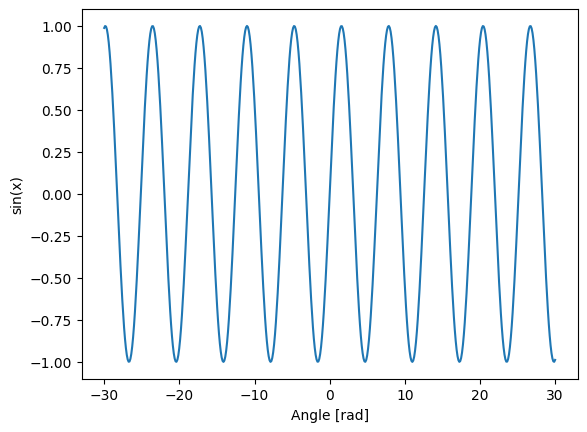

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as ks

x = np.linspace(-30, 30, 500)
plt.plot(x, np.sin(x))
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.show()

In [11]:
print(f"Bartek to QT{np.pi}")

Bartek to QT3.141592653589793
